# Manual Selection Cuts
Now we have made our neural networks and other MVA models we can make some better manual cuts. So this notebook quickly goes through some of them.

In [1]:
import numpy as np
import pandas as pd
import uproot as up
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use([hep.style.ROOT, hep.style.firamath])

In [2]:
sname = "/disk/moose/lhcb/djdt/Lb2L1520mueTuples/MC/2016MD/fullSampleOct2021/job207-CombDVntuple-15314000-MC2016MD_Full-pKmue-MC.root"
fname = "/disk/moose/lhcb/djdt/Lb2L1520mueTuples/realData/2016MD/halfSampleOct2021/blindedTriggeredL1520Selec-collision-firstHalf2016MD-pKmue_Fullv9.root"

# Request the same features that are used in the 6.0.4 dataset
features = list(dict.fromkeys([
    'Lb_PT', 'Lb_IPCHI2_OWNPV', 'Lb_ENDVERTEX_CHI2', 'Lb_HOP',
    'L2_IPCHI2_OWNPV', 'L1_IPCHI2_OWNPV', 'LStar_ORIVX_CHI2', 'LStar_DIRA_OWNPV',
    'JPs_FD_ORIVX', 'p_PZ', 'p_P', 'K_PZ', 'K_P', 'K_PY', 'K_PT', 'p_PY', 'p_PT',
    'K_P', 'Lb_L1_cmult_0.5TrkISO', 'Lb_L2_cmult_0.5TrkISO', 'Lb_p_cmult_0.5TrkISO',
    'Lb_K_cmult_0.5TrkISO', 'Lb_L1_cc_asy_PT_0.5ConeISO', 'Lb_L2_cc_asy_PT_0.5ConeISO',
    'Lb_p_cc_asy_PT_0.5ConeISO', 'Lb_K_cc_asy_PT_0.5ConeISO', 'Lb_P', 'Lb_PT',
    'Lb_MINIPCHI2', 'Lb_DIRA_OWNPV', 'p_ETA', 'L1_ETA', 'L2_ETA',
    'Lb_IP01', 'Lb_IP23', 'JPs_DIRA_TOPPV', 'Lb_IP_OWNPV', 'p_TRACK_VeloCHI2NDOF',
    'Lb_TAUERR', 'Lb_DTF_PV_decayLengthErr',
    'Lb_DTF_PV_Lambda_1520_0_decayLengthErr', 'K_TRACK_VeloCHI2NDOF', 'Lb_DTF_PV_chi2'
]))

# The features we still have to calculate
new_features = {
    'ABS_ARTANH_PZ_P': "np.abs(np.arctanh( p_PZ / p_P )-np.arctanh( K_PZ / K_P ))",
    'MAG_ARSINH_PY_PT': "np.sqrt((np.arcsinh( K_PY / K_PT )-np.arcsinh( p_PY / p_PT ))**2+(np.arcsinh( K_P / K_PT )-np.arcsinh( p_P / p_PT ))**2)",
    'SUM_CONE_ISO': " Lb_L1_cc_asy_PT_0.5ConeISO + Lb_L2_cc_asy_PT_0.5ConeISO + Lb_p_cc_asy_PT_0.5ConeISO + Lb_K_cc_asy_PT_0.5ConeISO ",
    'SUM_LIPCHI2': " L2_IPCHI2_OWNPV + L1_IPCHI2_OWNPV ",
    'LN_COS_THETA': "np.log(1-np.cos(np.arcsin( Lb_PT / Lb_P )))",
    'LN_LB_MINIPCHI2': "np.log( Lb_MINIPCHI2 )",
    'LN_COS_LBDIRA': "np.log(1-np.cos( Lb_DIRA_OWNPV ))",
    'LN_JPs_DIRA_TOPPV': "np.log( JPs_DIRA_TOPPV )"
}

# These are the only features we will end up keeping in the dataframe
keep_feats = list(dict.fromkeys([
    'ABS_ARTANH_PZ_P', 'MAG_ARSINH_PY_PT', 'SUM_CONE_ISO', 'LN_COS_THETA',
    'SUM_LIPCHI2', 'JPs_FD_ORIVX', 'LStar_DIRA_OWNPV',
    'LStar_ORIVX_CHI2', 'Lb_HOP', 'Lb_ENDVERTEX_CHI2',
    'Lb_IPCHI2_OWNPV', 'Lb_PT', 'LN_LB_MINIPCHI2', 'p_ETA',
    'L1_ETA', 'L2_ETA', 'Lb_IP01', 'Lb_IP23', 'LN_COS_LBDIRA', 
    'LN_JPs_DIRA_TOPPV', 'Lb_IP_OWNPV', 'p_TRACK_VeloCHI2NDOF', 
    'Lb_TAUERR', 'Lb_DTF_PV_decayLengthErr',
    'Lb_DTF_PV_Lambda_1520_0_decayLengthErr', 'K_TRACK_VeloCHI2NDOF', 
    'Lb_DTF_PV_chi2', 'category'
]))

## Gather and Produce Data

In [3]:
decayTree = ":DTT1520me/DecayTree"

with up.open(fname + decayTree) as f:
    real_df = f.arrays(["eventNumber"] + features, library="pd")
    real_df.set_index("eventNumber", inplace=True)
    real_df = real_df.sample(frac=1, random_state=0)
    real_df = real_df[~real_df.index.duplicated(keep='first')]
    
real_df['category'] = 0
# These are all background events

In [4]:
def add_df_prefix(boolean_mask, prefix):
        begin, end = False, False
        updated_mask = ''
        
        for i, char in enumerate(boolean_mask):
            updated_mask += char
            # Add the character to the current feature name
            if char == ' ' and not begin:
                # The beginning of a feature is when there is a space
                updated_mask = updated_mask[:-1]
                # Remove the space character added to the string
                updated_mask += f"{prefix}['"
                # This is the start of a new feature so add the appropriate prefix
                begin = True 
                # Set the begin position to the current position and update
                # the begin variable to show we have a beginning position
            elif char == ' ' and begin:
                # If a beginning position already exists this must be an end point
                updated_mask = updated_mask[:-1]
                # Remove the space character from the end of the string
                updated_mask += "']"
                # Add the closing bracket to match the dataframe wrapper
                end = True
                # Set the end position and update the end variable to be true
            if begin and end:
                # We have both a begin and end point
                begin, end = False, False
                # Reset the beginning and ending flags
        return updated_mask

In [5]:
for feat_name, feat_expression in new_features.items():
    feat_expression_modified = add_df_prefix(feat_expression, 'real_df')
    real_df[feat_name] = eval(feat_expression_modified)

/cvmfs/lhcbdev.cern.ch/conda/envs/default/2021-09-07_04-06/linux-64/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [6]:
real_df = real_df[keep_feats]
real_df.head()

,ABS_ARTANH_PZ_P,MAG_ARSINH_PY_PT,SUM_CONE_ISO,LN_COS_THETA,SUM_LIPCHI2,JPs_FD_ORIVX,LStar_DIRA_OWNPV,LStar_ORIVX_CHI2,Lb_HOP,Lb_ENDVERTEX_CHI2,...,LN_COS_LBDIRA,LN_JPs_DIRA_TOPPV,Lb_IP_OWNPV,p_TRACK_VeloCHI2NDOF,Lb_TAUERR,Lb_DTF_PV_decayLengthErr,Lb_DTF_PV_Lambda_1520_0_decayLengthErr,K_TRACK_VeloCHI2NDOF,Lb_DTF_PV_chi2,category
eventNumber,,,,,,,,,,,,,,,,,,,,,
2096209443,0.051970,0.052206,-2.082694,-4.336980,88.147579,0.393707,0.999706,22.960119,1.465392,22.960119,...,-0.777225,-0.000152,0.018387,0.576353,0.000028,0.177197,0.0,0.771128,24.264156,0
1324166371,0.615867,0.632130,-1.414801,-5.183503,539.006387,1.022093,-0.999875,31.309790,2.978940,31.309790,...,-0.777461,-0.000635,0.066705,0.611878,0.000045,0.152483,0.0,0.637352,46.213417,0
445000055,0.599252,0.595185,3.314549,-4.472129,588.904032,0.006554,0.996100,0.926091,1.076999,0.926091,...,-0.777228,-0.000049,0.041146,0.859767,0.000047,0.114494,0.0,0.694237,7.391745,0
1969348920,0.200928,0.250976,-0.149985,-3.970745,144.882007,0.037241,0.999796,9.714355,4.225720,9.714355,...,-0.777654,-0.002003,0.045372,0.594291,0.000043,0.144727,0.0,1.878072,20.586788,0
1485963838,0.136845,0.144415,-0.679560,-5.443367,155.975937,0.590336,0.999770,15.615678,0.102742,15.615678,...,-0.777287,-0.000197,0.044930,0.847769,0.000048,0.261411,0.0,0.819781,23.234503,0


Now do the same for the simulated data...

In [7]:
decayTree = ":DTT1520me/DecayTree"

with up.open(sname + decayTree) as f:
    sim_df = f.arrays(["eventNumber", "Lb_BKGCAT"] + features, library="pd")
    sim_df.set_index("eventNumber", inplace=True)
    sim_df = sim_df.sample(frac=1, random_state=0)
    sim_df = sim_df[~sim_df.index.duplicated(keep='first')]
    
sim_df['category'] = np.where(sim_df['Lb_BKGCAT'].isin([10, 50]), 1, 0)
# These are all background events

In [8]:
for feat_name, feat_expression in new_features.items():
    feat_expression_modified = add_df_prefix(feat_expression, 'sim_df')
    sim_df[feat_name] = eval(feat_expression_modified)
    
sim_df = sim_df[keep_feats]
sim_df.head()

/cvmfs/lhcbdev.cern.ch/conda/envs/default/2021-09-07_04-06/linux-64/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,ABS_ARTANH_PZ_P,MAG_ARSINH_PY_PT,SUM_CONE_ISO,LN_COS_THETA,SUM_LIPCHI2,JPs_FD_ORIVX,LStar_DIRA_OWNPV,LStar_ORIVX_CHI2,Lb_HOP,Lb_ENDVERTEX_CHI2,...,LN_COS_LBDIRA,LN_JPs_DIRA_TOPPV,Lb_IP_OWNPV,p_TRACK_VeloCHI2NDOF,Lb_TAUERR,Lb_DTF_PV_decayLengthErr,Lb_DTF_PV_Lambda_1520_0_decayLengthErr,K_TRACK_VeloCHI2NDOF,Lb_DTF_PV_chi2,category
eventNumber,,,,,,,,,,,,,,,,,,,,,
393254,0.001463,0.001832,-0.354165,-5.935217,160.807998,0.072119,0.999997,5.978355,0.542964,5.978355,...,-0.777348,-0.000810,0.052227,0.550981,0.000019,0.210950,0.0,0.589864,4.410571,0
658592,0.190737,0.326799,1.850129,-5.959903,2573.744243,1.422825,0.997707,9.337301,1.016305,9.337301,...,-0.777186,-0.000087,0.005783,1.346191,0.000031,0.215495,0.0,1.021230,55366.464844,1
1267025,0.353597,0.933926,1.189212,-4.140072,312.615688,0.345475,0.991683,8.931516,0.921910,8.931516,...,-0.777249,-0.002318,0.027401,1.378245,0.000054,0.142816,0.0,0.772324,10.869309,1
159729,0.371461,0.395382,-0.165834,-6.603963,990.170116,0.087771,0.995782,3.830041,1.176228,3.830041,...,-0.777201,-0.000129,0.036817,1.254039,0.000059,0.219889,0.0,0.987966,7.201735,0
943698,0.275890,0.340636,1.526137,-5.290453,893.732966,0.388696,0.984800,7.431165,1.125189,7.431165,...,-0.777189,-0.003526,0.010842,0.879305,0.000049,0.159914,0.0,0.343524,66550.820312,0


## Investigate Features

In [9]:
NBINS = 60
g = sim_df.groupby('category')

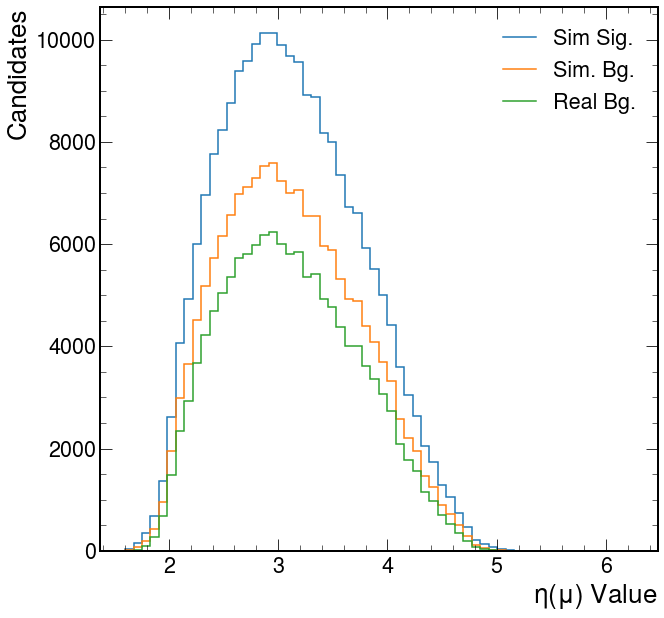

<Figure size 720x720 with 0 Axes>

In [13]:
for q in ['L1_ETA']:
    test_feature = q
    
    # Find a bin distribution that will suit all the data...
    min_feat_value = np.min(pd.concat([real_df[test_feature], sim_df[test_feature]]).to_numpy())
    max_feat_value = np.mean(pd.concat([real_df[test_feature], sim_df[test_feature]]).to_numpy())+5*np.std(pd.concat([real_df[test_feature], sim_df[test_feature]]).to_numpy())
    bins = np.linspace(min_feat_value, max_feat_value, NBINS+1)

    h_real, _ = np.histogram(real_df[test_feature][real_df[test_feature].between(min_feat_value, max_feat_value)], bins=bins,)
    h_fakebg, _ = np.histogram(g.get_group(0)[test_feature][g.get_group(0)[test_feature].between(min_feat_value, max_feat_value)], bins=bins)
    h_sig, _ = np.histogram(g.get_group(1)[test_feature][g.get_group(1)[test_feature].between(min_feat_value, max_feat_value)], bins=bins)
    
    fig, ax = plt.subplots(1, 1)
    hep.histplot([h_real, h_fakebg, h_sig], bins, ax=ax, stack=True, label=['Real Bg.', 'Sim. Bg.', 'Sim Sig.'])
    #plt.title(f'Distribution of {test_feature}')
    plt.ylabel('Candidates')
    plt.xlabel(r'$\eta(\mu)$ Value')
    plt.legend()
    plt.savefig(f'../images/ManualCuts/{test_feature}.png', dpi=800)
    plt.show()
    plt.clf()